<a href="https://colab.research.google.com/github/nickbohall/NFL_Betting_Model/blob/main/Historical_Rest_Edges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is an analysis to see the correlation between the difference in "rest" in head to head matchups between NFL teams

This analysis was inspired by analysis by Warren Sharp: https://twitter.com/SharpFootball/status/1658514772197769232?t=T8QykJvkb0R_B-EP4mBHNg&s=19

Imports. I don't actually need all of these. 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from functools import reduce
from datetime import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading in the data. The data comes from an NFL_API that I pulled and configued in PyCharm and outputted to csv. Credit: **nfl_data_py**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NFL Model/Data/API Data/schedule_2002_to_2022.csv", index_col=0)
df

,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,home_team,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
777,2002_01_SF_NYG,2002,REG,1,2002-09-05,Thursday,20:30,SF,16.0,NYG,...,7.0,00-0005755,00-0003292,Jeff Garcia,Kerry Collins,Steve Mariucci,Jim Fassel,Gerry Austin,NYC00,Giants Stadium
778,2002_01_NYJ_BUF,2002,REG,1,2002-09-08,Sunday,13:00,NYJ,37.0,BUF,...,6.0,00-0016193,00-0001361,Vinny Testaverde,Drew Bledsoe,Herm Edwards,Gregg Williams,Bob McElwee,BUF00,Ralph Wilson Stadium
779,2002_01_BAL_CAR,2002,REG,1,2002-09-08,Sunday,13:00,BAL,7.0,CAR,...,12.0,00-0019709,00-0012732,Chris Redman,Rodney Peete,Brian Billick,John Fox,Walt Coleman,CAR00,Ericsson Stadium
780,2002_01_MIN_CHI,2002,REG,1,2002-09-08,Sunday,13:00,MIN,23.0,CHI,...,3.0,00-0003739,00-0011276,Daunte Culpepper,Jim Miller,Mike Tice,Dick Jauron,Mike Carey,CHI99,Memorial Stadium (Champaign)
781,2002_01_SD_CIN,2002,REG,1,2002-09-08,Sunday,13:00,SD,34.0,CIN,...,7.0,00-0020531,00-0005589,Drew Brees,Gus Frerotte,Marty Schottenheimer,Dick LeBeau,Johnny Grier,CIN00,Paul Brown Stadium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6416,2022_20_CIN_BUF,2022,DIV,20,2023-01-22,Sunday,15:00,CIN,27.0,BUF,...,4.0,00-0036442,00-0034857,Joe Burrow,Josh Allen,Zac Taylor,Sean McDermott,Carl Cheffers,BUF00,New Era Field
6417,2022_20_DAL_SF,2022,DIV,20,2023-01-22,Sunday,18:30,DAL,12.0,SF,...,19.0,00-0033077,00-0037834,Dak Prescott,Brock Purdy,Mike McCarthy,Kyle Shanahan,Bill Vinovich,SFO01,Levi's Stadium
6418,2022_21_SF_PHI,2022,CON,21,2023-01-29,Sunday,15:00,SF,7.0,PHI,...,14.0,00-0037834,00-0036389,Brock Purdy,Jalen Hurts,Kyle Shanahan,Nick Sirianni,John Hussey,PHI00,Lincoln Financial Field
6419,2022_21_CIN_KC,2022,CON,21,2023-01-29,Sunday,18:30,CIN,20.0,KC,...,13.0,00-0036442,00-0033873,Joe Burrow,Patrick Mahomes,Zac Taylor,Andy Reid,Ron Torbert,KAN00,GEHA Field at Arrowhead Stadium


Defining Home edge. This is the number of days each team had to prepare for the game.


In [ ]:
df["home_rest_edge"] = df.home_rest - df.away_rest
df["away_rest_edge"] = df.away_rest - df.home_rest

Grouping by the rest edge and limiting to 1 day, 3 day, and 7 day on each side. The others didn't have enough samples to be significant.

In [ ]:
home_df = df[["home_rest_edge", "result"]]
home_df.groupby("home_rest_edge").count()

,result
home_rest_edge,
-8,26
-7,227
-6,24
-4,34
-3,240
-2,24
-1,405
0,3776
1,315


In [ ]:
home_df = home_df.groupby(by="home_rest_edge").mean().reset_index()
home_df = home_df[ ( home_df["home_rest_edge"] == 7) | (home_df["home_rest_edge"] == -7) | (home_df["home_rest_edge"] == -3) | (home_df["home_rest_edge"] == 3) | (home_df["home_rest_edge"] == -1) | (home_df["home_rest_edge"] == 1) | (home_df["home_rest_edge"] == 0) ]
home_df

,home_rest_edge,result
1,-7,0.511013
4,-3,1.562500
6,-1,3.256790
7,0,2.101960
8,1,1.869841
10,3,2.856354
13,7,3.697917


Just setting everything up to plot & then plotting. Results below.

In [ ]:
# set x and y
x = home_df.home_rest_edge
y = home_df.result

# calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

<ipython-input-7-79dce360d0f6>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

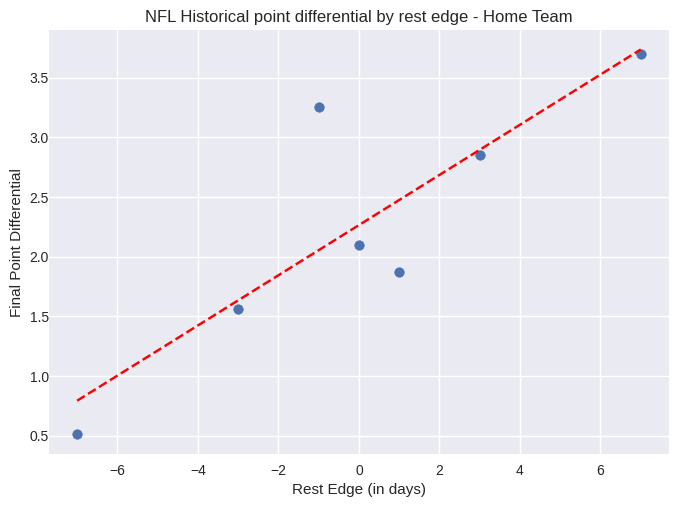

In [ ]:
plt.style.use('seaborn')

# Create the subplot function
fig, ax = plt.subplots()

# Plot the scatter
ax.scatter(x,y)

# Plot the trendline
ax.plot(x, p(x), color="red", linestyle="--")

# Titles and axes
plt.title("NFL Historical point differential by rest edge - Home Team")
plt.xlabel("Rest Edge (in days)")
plt.ylabel("Final Point Differential")

# Move left y-axis and bottom x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')

# Put ticks and labels back on the left
plt.setp(ax.get_yticklabels(), transform=ax.get_yaxis_transform())